In [2]:
import convokit

In [3]:
from convokit import Corpus, download

### Downloading dataset

In [4]:
de = Corpus(filename=download("subreddit-de"))
germany = Corpus(filename=download("subreddit-germany"))

Dataset already exists at /Users/nianyiwang/.convokit/downloads/subreddit-de
Dataset already exists at /Users/nianyiwang/.convokit/downloads/subreddit-germany


#### Getting common users

In [5]:
eng_users = set()
de_users=set()
for usr in de.iter_users():
    de_users.add(usr.name)
for usr in germany.iter_users():
    eng_users.add(usr.name)

In [6]:
common_users = list(eng_users.intersection(de_users))
print(len(common_users))
eng_only_users = list(eng_users.difference(de_users))
print(len(eng_only_users))

14072
43550


In [7]:
common_users[0]

'IamVasi'

#### Extract texts that bilingual users posted in English

In [8]:
user_conv = {}
for utt in germany.iter_utterances():
    usr = utt.user.name
    if usr not in common_users or usr == '[deleted]':
        continue
    if usr not in user_conv and utt.text != '':
        user_conv[usr] = [utt.text]
    elif usr in user_conv and utt.text != '':
        user_conv[usr].append(utt.text)

In [9]:
print(user_conv['panda527'])
print(len(user_conv))

['Come of you please give us some context?', 'It actually is, the lower plaque below the old ASU sticker is gone.', "True that - nothing really wants to kill you in German Forests... just make sure to follow any posted warnings for tree felling and you should be good.\nOh yeah and don't just eat any mushroom! Enjoy!", 'G’socks\ngrattler', 'I heard Congstar is great for such needs.', 'I would also add your education to this. If you are a hairdresser and make six figures with your own salon big props - if you are a automotive engineer in Munich or Stuttgart and are living in your parents basement at the age of 30 because you can’t afford to move out .. well then there is something off.']
13621


#### Constructing training set
12000 bilingual users and 12000 no cross-over users

In [10]:
import random
bi_users = list(user_conv.keys())
random.shuffle(bi_users)
bi_users = bi_users[:12000]
bi_utt = {}
for usr in bi_users:
    bi_utt[usr] = user_conv[usr]

#### This part can be loaded from sin_utt.json

In [11]:
# sin_utts = {}
# for utt in germany.iter_utterances():
#     usr = utt.user.name
#     if usr not in eng_only_users[:14000] or usr == '[deleted]':
#         continue
#     if usr not in sin_utts and utt.text != '':
#         sin_utts[usr] = [utt.text]
#     elif usr in sin_utts and utt.text != '':
#         sin_utts[usr].append(utt.text)
# sin_users = list(sin_utts.keys())
# random.shuffle(sin_users)
# sin_users = sin_users[:12000]
# sin_utt = {}
# for usr in sin_users:
#     sin_utt[usr] = sin_utts[usr]

#### Dumping data to json file

In [17]:
import json
with open('bi_utt.json', 'w') as outfile:
    json.dump(bi_utt, outfile)
# with open('sin_utt.json', 'w') as outfile:
#     json.dump(sin_utt, outfile)

In [26]:
print(bi_utt['I_Like_Spaghetti'])
print(sin_utt['wxsted'])

['What do blondes and spaghetti have in common? They both wiggle when you eat them.', 'What do blondes and spaghetti have in common? They both wiggle when you eat them.', '(╯ಠ_ಠ）╯︵ ┻━┻', 'Did you hear about the Italian chef that died? He pasta way. ']
["The comments are a madness of people saying all kinds of xenophobe, Islamophobe and racist insults fighting with others defending Muslims and refugees. The only proof we have that he was a refugee is that the guy who uploaded the video put that in the title as nobody understands what they're saying. I want to know whether this is real news or bullshit to try to finish all that stupidity. Thanks in advance from a Spanish fellow!\n\nEdit: I mean, of course the video itself is true. What I meant to ask is if it's true that the perpetrator is a refugee.", "If you were trying to be funny, you didn't achieve it. Don't joke about such things.", "Thanks. I don't get why are there so many people saying things like what Livohka says", 'So, who is

### Creating TF-IDF Matrix and applying Logistic Regression

In [1]:
import json

bi_utt={}
with open('bi_utt.json') as json_file:
    data = json.load(json_file)
    for usr in data:
        bi_utt[usr] = data[usr]

sin_utt={}
with open('sin_utt.json') as json_file:
    data = json.load(json_file)
    for usr in data:
        sin_utt[usr] = data[usr]

In [2]:
import numpy as np
texts = []
labels = []
for usr in bi_utt:
    for post in bi_utt[usr]:
        texts.append(post)
        labels.append(1)
for usr in sin_utt:
    for post in sin_utt[usr]:
        texts.append(post)
        labels.append(0)

In [36]:
print(labels.count(0), labels.count(1))

75268 396315


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

In [4]:
tfidf = vectorizer.fit_transform(texts)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
xtrain, xtest, ytrain, ytest = train_test_split( 
        tfidf, labels, test_size = 0.25, random_state = 0) 

In [9]:
clf = LogisticRegression(random_state=0, solver='newton-cg',multi_class='multinomial').fit(xtrain, ytrain)

In [10]:
from sklearn.metrics import accuracy_score 
y_pred = clf.predict(xtest) 

In [11]:
print ("Accuracy : ", accuracy_score(ytest, y_pred)) 

Accuracy :  0.8520645314514488


Confusion matrix, without normalization
[[ 2959 15821]
 [ 1620 97496]]
Normalized confusion matrix
[[0.16 0.84]
 [0.02 0.98]]


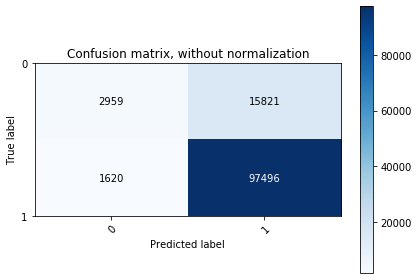

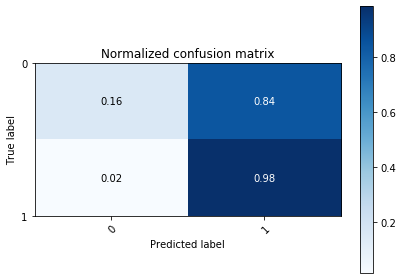

In [31]:
from sklearn.metrics import confusion_matrix 
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0,1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        if i % 2 == 0 : 
            pos = i+0.25 
        else: pos = i-0.25
        for j in range(cm.shape[1]):
            ax.text(j, pos, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)
class_names=[0,1]

# Plot non-normalized confusion matrix
plot_confusion_matrix(ytest, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(ytest, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [35]:
print(ytest.count(1))
print(ytest.count(0))

99116
18780
